In [ ]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from scipy import stats
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as tools
from scipy.stats import probplot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
today = datetime.today()
days = timedelta(days=1000)
start = today-days

In [4]:
print('start:', start, '\t', 'end:', today)

start: 2019-05-02 02:58:30.681744 	 end: 2022-01-26 02:58:30.681744


In [5]:
stk = 'EBAY'
stk = yf.download(stk, start, today)
df = stk['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [6]:
ret = pd.DataFrame()
ret['Daily Return'] = df.pct_change(1)
ret.dropna(inplace=True)
ret

,Daily Return
Date,
2019-05-03,0.018356
2019-05-06,-0.010449
2019-05-07,-0.005280
2019-05-08,-0.003716
2019-05-09,0.002131
...,...
2022-01-19,0.011037
2022-01-20,-0.025365
2022-01-21,-0.019272


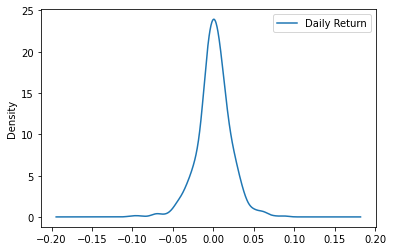

In [7]:
# Density plot of returns

ret.plot.density()

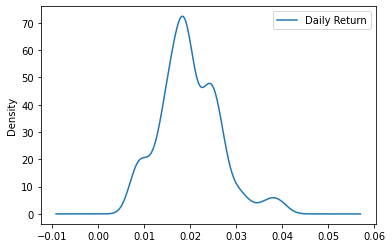

In [8]:
# Volatility plot of returns

ret_std = ret.rolling(window=30, min_periods=30).std()
ret_std.plot.density()

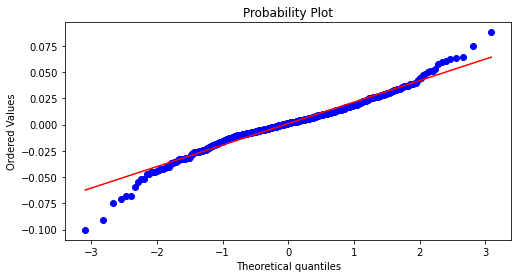

In [9]:
# quantile-quantile plot of returns
# visualize points that lie outside the line for positive and negative skews
figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
stats.probplot(ret['Daily Return'], dist='norm', plot=ax)
plt.show()

In [10]:
# test if returns are normally distributed
# first value is the test statistic and the second is the p-value

stats.shapiro(ret['Daily Return'])
# the p-value is small enough to reject the null-hypotesis that the returns follow a normal distribution

(0.969105064868927, 7.067109397684845e-11)

Skewness indicates whether the distribution is skewed to the left or right. A symmetric distribution has a skewness of zero.

$skew = \frac{Σ^n_i(R_i-\overline{R})^3}{(n-1)σ^3}$

In [11]:
stats.skew(ret['Daily Return'])

-0.26600859775120383

Kurtosis reflects the impact of extreme returns. A normal distribution has a kutosis of 3. 

kurtosis = $\frac{Σ^n_i(R_i-\overline{R})^4}{(n-1)σ^4}$

In [12]:
stats.kurtosis(ret['Daily Return'])

2.505448893296852

T-test tests if the mean is zero. 

In [13]:
stats.ttest_1samp(ret['Daily Return'],0)
# do not reject the null-hypothesis
# the mean return is zero

Ttest_1sampResult(statistic=1.1425317129048091, pvalue=0.25363051413278925)

Durbin-Watson test statistic measures auto-correlation.

$DW = \frac{Σ^T_t(e_t - e_{t-1})^2}{Σ^T_te^2_t}$

Symbol $e_𝘵$ is the error term (at time  $t, T$) is the total number of error term. The Durbin-Watson statistic tests the null hypothesis that the residuals from an ordinary least-squares regression are not auto-correlated against the alternative that the residuals follow an AR1 process. The Durbin-Watson statistic ranges in value from 0 to 4. A value near 2 indicates non-autocorrelation; a value toward 0 indicates positive autocorrelation; a value toward 4 indicates negative autocorrelation.

Augmented Dickey-Fuller Test (ADF) determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed on the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is non-stationary. Lower values of ADF indicates stronger rejection of the null hypothesis.

In [14]:
# A test for stationarity is the augmented Dickey–Fuller test
# The second return value is the p-value
# With p-values below 5% or 0.05 we would typically reject the null hypothesis, 
# and we could assume that our time-series is stationary
from statsmodels.tsa.stattools import adfuller
adfuller(ret['Daily Return'])[1]

0.0

The  Autoregressive Integrated Moving Average  (ARIMA) is a forecasting model for stationary  time  series.

* Autoregression  (AR): Uses the dependency between an observation and its lagged values 

* AR(p) $Y_t = c + 𝜙y_l1 + 𝜙yl2 + e_t$

* Integrated  (I): The use of differencing an observation with an observation from a previous time stamp in making the time series stationary 

* Moving average  (MA): Uses the dependency between an observed error term and a combination of previous error terms,  $e_t$

* MA(q) $Y_t = c + 𝜙e_l1 + 𝜙el2 + e_t$

* ARIMA models are referenced by the notation  ARIMA(p, d, q)

In [15]:
# Trend and Seasonality function
from numpy import polyfit
def fit(X, y, degree=3):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)
def get_season(s, yearly_periods=260, degree=3):
    X = [i%(yearly_periods) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)
def get_trend(s, degree=3):
    X = list(range(len(s)))
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

In [16]:
data = pd.DataFrame(df.copy())
data.head()

,Adj Close
Date,
2019-05-02,36.238895
2019-05-03,36.904099
2019-05-06,36.518478
2019-05-07,36.325668
2019-05-08,36.190697


Text(0, 0.5, 'Price')

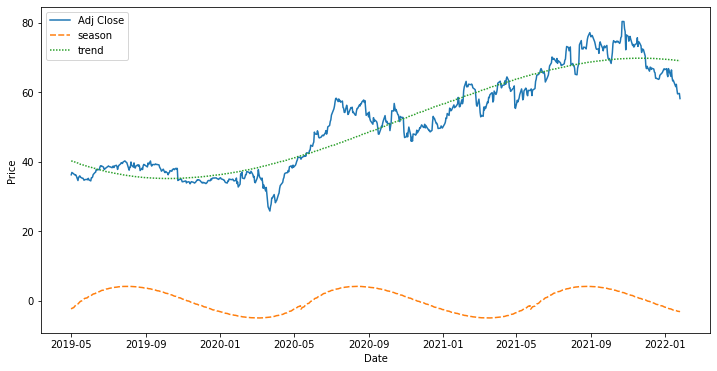

In [17]:
#Trend and Seasonality plot of returns
plt.figure(figsize=(12, 6))
data['trend'] = get_trend(data['Adj Close'])
data['season'] = get_season(data['Adj Close'] - data['trend'])
sns.lineplot(data=data[['Adj Close', 'season', 'trend']])
plt.ylabel('Price')

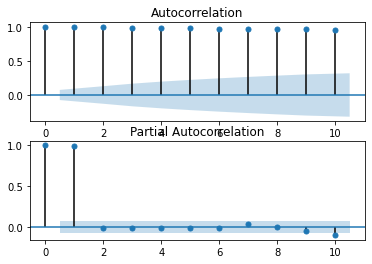

In [25]:
# correlation of each daily price lag
import statsmodels.api as sm
fig, axes = plt.subplots(nrows=2, ncols=1)
sm.graphics.tsa.plot_acf(df, lags=10, ax=axes[0]);
sm.graphics.tsa.plot_pacf(df, lags=10, ax=axes[1]);

In [29]:
# create arima model
model = sm.tsa.ARIMA(df, order=(10,0,1))
fitted = model.fit(trend="c")
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Adj Close   No. Observations:                  690
Model:                    ARMA(10, 1)   Log Likelihood               -1031.911
Method:                       css-mle   S.D. of innovations              1.076
Date:                Wed, 26 Jan 2022   AIC                           2089.822
Time:                        03:01:41   BIC                           2148.799
Sample:                             0   HQIC                          2112.635
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               49.2581      8.749      5.630      0.000      32.110      66.407
ar.L1.Adj Close      0.6313      0.215      2.937      0.003       0.210       1.053
ar.L2.Adj Close      0.3719 

In [32]:
forecast, std_err, fc_ci = fitted.forecast(steps=10)
forecast_dates = pd.date_range(today, periods=10)
forecast = pd.Series(forecast, index=forecast_dates)

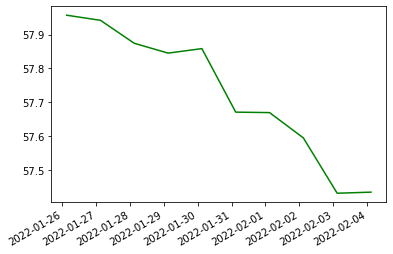

In [33]:
forecast.plot(c="g", label="Forecast")

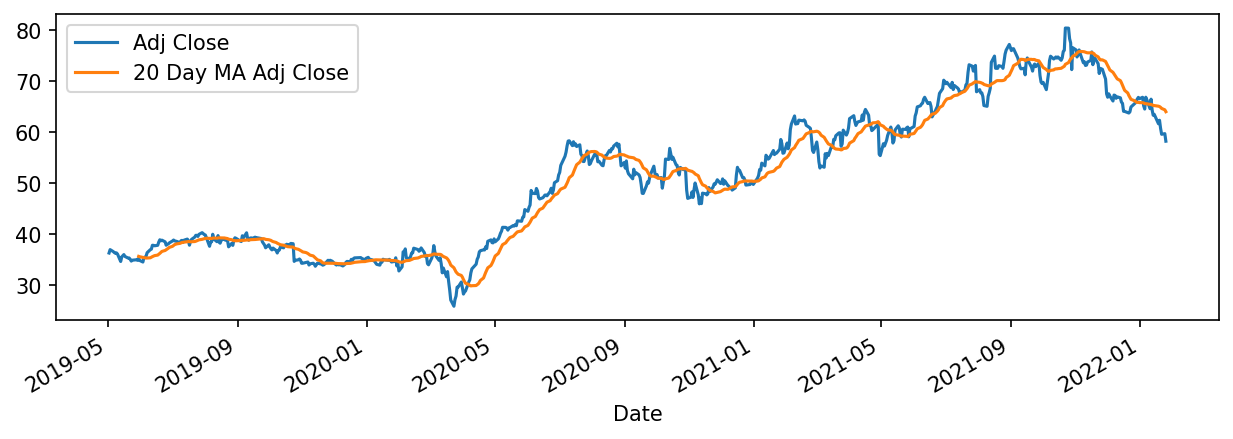

In [22]:
# Plot of 20-day moving average

plt.figure(figsize=(10,3),dpi=150)
data['Adj Close'].plot(label='Adj Close')
data.rolling(window=20).mean()['Adj Close'].plot(label='20 Day MA Adj Close')
plt.legend()